Importing Libraries
In this step, we import the libraries required for data analysis, visualization, text processing, and feature extraction:

pandas & numpy → For working with tabular datasets and numerical computations.
matplotlib & seaborn → For generating charts and plots to visualize data distributions and class imbalance.
WordCloud → To create word clouds that highlight the most frequent terms per medical specialty.
datasets (Hugging Face) → To load the clinical dataset (medical-cases-classification-tutorial) directly.
TfidfVectorizer (Scikit-learn) → For converting clinical text into numerical TF-IDF vectors (used later in preprocessing).
We also set Seaborn’s style to "whitegrid" for cleaner, more professional-looking plots.

In [1]:
# ==============================
# 1. Imports
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from datasets import load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer

# Plot style
sns.set(style="whitegrid")

Loading the Dataset
We load the clinical dataset medical-cases-classification-tutorial from the Hugging Face datasets library.
This dataset contains clinical case descriptions, physician transcriptions, and their corresponding medical specialties.

train_df → Training split (used for building models).
val_df → Validation split (used for hyperparameter tuning).
test_df → Test split (used for final model evaluation).
We then print the shape of each split to confirm dataset sizes and display the first few rows of the training set for inspection.

In [2]:
# ==============================
# 2. Load Dataset
# ==============================
ds = load_dataset("hpe-ai/medical-cases-classification-tutorial")

train_df = ds["train"].to_pandas()
val_df   = ds["validation"].to_pandas()
test_df  = ds["test"].to_pandas()

print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape)
train_df.head()


Repo card metadata block was not found. Setting CardData to empty.


Train: (1724, 5) Val: (370, 5) Test: (370, 5)


,description,transcription,sample_name,medical_specialty,keywords
0,Pacemaker ICD interrogation. Severe nonischem...,"PROCEDURE NOTE: , Pacemaker ICD interrogation....",Pacemaker Interrogation,Cardiovascular / Pulmonary,"cardiovascular / pulmonary, cardiomyopathy, ve..."
1,"Erythema of the right knee and leg, possible s...","PREOPERATIVE DIAGNOSES: , Erythema of the righ...",Aspiration - Knee Joint,Orthopedic,"orthopedic, knee and leg, anterolateral portal..."
2,Left cardiac catheterization with selective ri...,"PREOPERATIVE DIAGNOSIS: , Post infarct angina....",Cardiac Cath & Selective Coronary Angiography,Cardiovascular / Pulmonary,"cardiovascular / pulmonary, selective, angiogr..."
3,Patient with a history of coronary artery dise...,"REASON FOR VISIT: , Acute kidney failure.,HIST...",Acute Kidney Failure,Nephrology,None
4,Cardiac evaluation and treatment in a patient ...,"REASON FOR REFERRAL: , Cardiac evaluation and ...",Cardiac Consultation - 6,Cardiovascular / Pulmonary,None


Dataset Dictionary (Table 2)
Before modeling, it is essential to fully understand the dataset schema.
The table below describes each feature, its type, purpose, and any potential issues.

description → Short case summary (auxiliary feature).
transcription → Main text input, but lengthy and noisy. Requires preprocessing (cleaning, tokenization, TF-IDF).
sample_name → Identifier, not useful for prediction. Will be excluded from training.
medical_specialty → Target variable (13 categories). Imbalanced distribution requires stratified evaluation.
keywords → May duplicate transcription content but can help in feature engineering.

In [3]:
# ==============================
# 3. Table 2: Dataset Dictionary
# ==============================
data_dict = pd.DataFrame({
    "Feature Name": ["description", "transcription", "sample_name", "medical_specialty", "keywords"],
    "Data Type": ["Text (string)", "Text (string)", "Text (string)", "Categorical (string)", "Text (string)"],
    "Description": [
        "A short summary of the medical case.",
        "Full, detailed transcription of physician’s notes or report.",
        "A title or name for the medical case sample.",
        "Target variable: the medical specialty (13 classes).",
        "List of keywords associated with the case."
    ],
    "Notes / Potential Issues": [
        "Useful as concise feature source.",
        "Primary source, long and complex; requires cleaning, tokenization, TF-IDF.",
        "Likely just an identifier → exclude from training.",
        "Imbalanced distribution → stratify and evaluate with precision/recall/F1.",
        "May be redundant, but useful for feature engineering."
    ]
})

data_dict


,Feature Name,Data Type,Description,Notes / Potential Issues
0,description,Text (string),A short summary of the medical case.,Useful as concise feature source.
1,transcription,Text (string),"Full, detailed transcription of physician’s no...","Primary source, long and complex; requires cle..."
2,sample_name,Text (string),A title or name for the medical case sample.,Likely just an identifier → exclude from train...
3,medical_specialty,Categorical (string),Target variable: the medical specialty (13 cla...,Imbalanced distribution → stratify and evaluat...
4,keywords,Text (string),List of keywords associated with the case.,"May be redundant, but useful for feature engin..."


Target Variable Distribution
To understand potential class imbalance, we plot the distribution of the medical_specialty target variable.

There are 13 distinct classes.
Some specialties (e.g., Cardiovascular / Pulmonary) dominate the dataset.
Others (e.g., Psychiatry, Urology) have very few samples.
This imbalance must be considered during training and evaluation, as models tend to favor majority classes unless handled carefully.

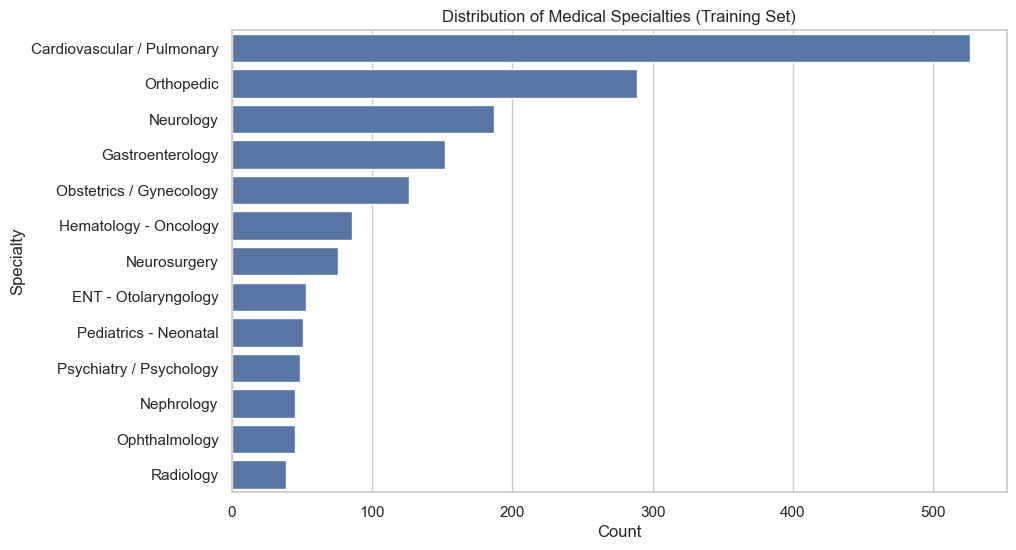

In [4]:
# ==============================
# 4. Target Variable Distribution
# ==============================
plt.figure(figsize=(10,6))
sns.countplot(y="medical_specialty", data=train_df,
              order=train_df["medical_specialty"].value_counts().index)
plt.title("Distribution of Medical Specialties (Training Set)")
plt.xlabel("Count")
plt.ylabel("Specialty")
plt.show()


Document Length Analysis
To better understand the complexity of our text data, we analyze the character length distributions of both the transcription and description fields.

Transcriptions are the detailed physician notes, expected to be long and information-rich.
Descriptions are short summaries of the cases.
This analysis helps us confirm which field provides the most useful signal for classification.

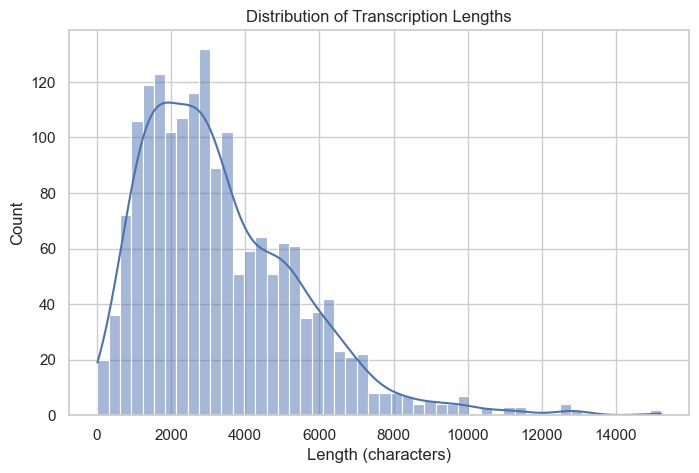

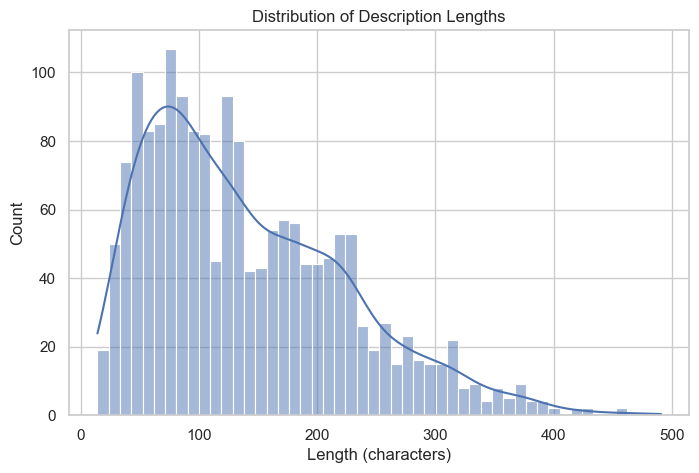

Avg transcription length: 3326.159512761021
Avg description length: 140.4002320185615


In [5]:
# ==============================
# 5. Document Length Analysis
# ==============================
train_df["transcription_length"] = train_df["transcription"].fillna("").apply(len)
train_df["description_length"]   = train_df["description"].fillna("").apply(len)

plt.figure(figsize=(8,5))
sns.histplot(train_df["transcription_length"], bins=50, kde=True)
plt.title("Distribution of Transcription Lengths")
plt.xlabel("Length (characters)")
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(train_df["description_length"], bins=50, kde=True)
plt.title("Distribution of Description Lengths")
plt.xlabel("Length (characters)")
plt.show()

print("Avg transcription length:", train_df["transcription_length"].mean())
print("Avg description length:", train_df["description_length"].mean())


Word Clouds for Top Specialties
To better understand the vocabulary associated with each specialty, we generate Word Clouds for the three most frequent classes in the training set.

Each Word Cloud shows the most common terms in the transcription field for that specialty.
Common English stopwords (e.g., the, and, of) are removed so only domain-specific terms remain.
This visualization helps confirm whether different specialties are distinguished by unique medical terminology.

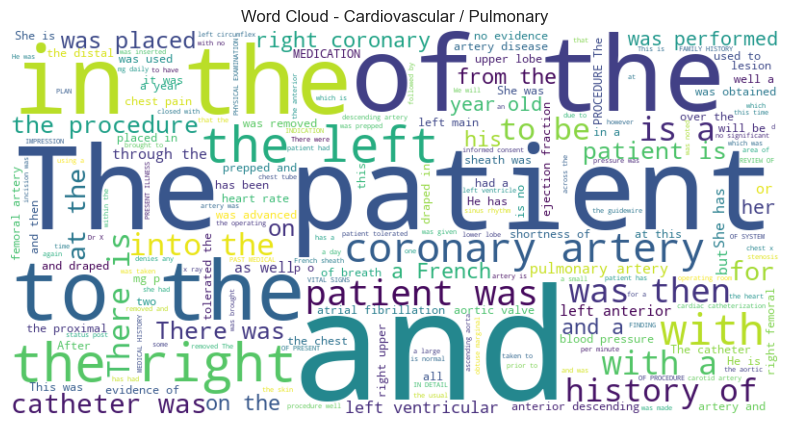

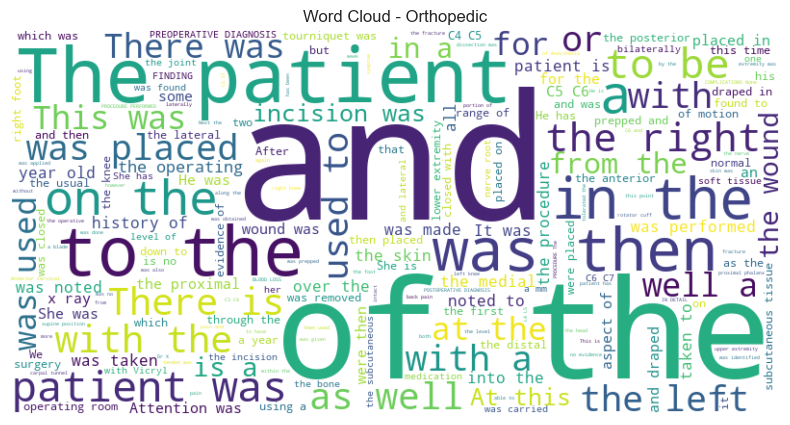

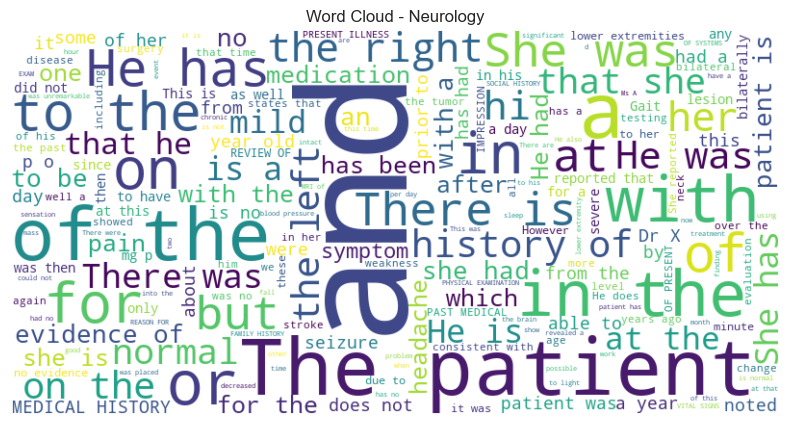

In [6]:
# ==============================
# 6. Word Clouds for Top Specialties
# ==============================
specialties = train_df["medical_specialty"].value_counts().index[:3]  # top 3 specialties
for spec in specialties:
    text = " ".join(train_df[train_df["medical_specialty"]==spec]["transcription"].dropna().astype(str))
    wc = WordCloud(width=800, height=400, background_color="white", stopwords="english").generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud - {spec}")
    plt.show()

Preprocessing Pipeline (TF-IDF)
In this step, we convert the clinical text data into a numerical format that machine learning models can process.
We use the TF-IDF (Term Frequency-Inverse Document Frequency) vectorization method to transform the physician transcriptions.

tfidf = TfidfVectorizer(
    lowercase=True,          # 1. Text cleaning: convert all text to lowercase
    stop_words="english",    # 2. Stop word removal: remove common words like 'the', 'and', etc.
    ngram_range=(1,2),       # 3. Unigrams + Bigrams: consider single words and two-word phrases
    max_features=20000       # 4. Limit vocabulary size to top 20,000 features
)

X_tfidf = tfidf.fit_transform(train_df["transcription"].fillna(""))
print("TF-IDF Matrix Shape:", X_tfidf.shape)

In [7]:
# ==============================
# 7. Preprocessing Pipeline (TF-IDF)
# ==============================
tfidf = TfidfVectorizer(
    lowercase=True,          # 1. text cleaning
    stop_words="english",    # 2. stop word removal
    ngram_range=(1,2),       # 3. unigrams + bigrams
    max_features=20000       # 4. limit vocab size
)

X_tfidf = tfidf.fit_transform(train_df["transcription"].fillna(""))
print("TF-IDF Matrix Shape:", X_tfidf.shape)


TF-IDF Matrix Shape: (1724, 20000)
